In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pprint as pprint

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, TargetEncoder
from scipy.stats import boxcox

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score,median_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


%matplotlib inline
pd.set_option('display.max_columns',None)

In [2]:
def readData(inputPath,fileName):
    
    print("Data has been read")
    return pd.read_csv(inputPath+fileName+'.csv')

In [3]:
def cleanData(df):
    
    # 1. Replace special values with np.nan
    for col in df.select_dtypes(include='object').columns:
        df[col].replace(r'^\s*$', np.nan, regex=True, inplace=True)
        df[col].replace("NaN", np.nan, regex=True, inplace=True)
    
    
    # 2. Drop columns with missing values greater than or equal to 10%
    
    missingColumns=((df.isnull().sum()/len(df))*100).to_dict()
    zeroColumns=(((df==0).sum()/len(df))*100).to_dict()
    featureValueCounts=dict(df.nunique().sort_values(ascending=False))

    l=[]
    l.append('Id')
            # Remove columns whose missing values % is >=10%
    for key,value in missingColumns.items():
        if value>=10:
            l.append(key)
 
            # Remove columns whose missing values % is >=10%
    for key,value in zeroColumns.items():
        if value>=10:
            l.append(key)
            
            # Remove Columns which contains only one value
    for key,value in featureValueCounts.items():
        if value==1:
            l.append(key)
    df.drop(columns=l,axis=1,inplace=True)
    
    df.dropna(how='any',inplace=True)
    
    # Identify columns based on the data type
    objectColumns=[col for col in df.columns if df[col].dtype=='object']
    numericColumns=[col for col in df.columns if df[col].dtype!='object']
    
    
    # 3. Outlier Removal based on IQR range
    for col in numericColumns:
        Q1=df[col].quantile(0.25)
        Q3=df[col].quantile(0.75)
    
        IQR=Q3-Q1
    
        lowerbound = Q1-1.5*IQR
        upperbound = Q3+1.5*IQR
        df=df[(df[col]>=lowerbound) & (df[col]<=upperbound)]
    
    
    
    print("Data has been cleaned")
    # Final. Return cleaned dataset
    
    return df, lowerbound,upperbound

In [26]:
def testCleanData(df,trainLowerBound,trainUpperBound):
    
    # 1. Replace special values with np.nan
    for col in df.select_dtypes(include='object').columns:
        df[col].replace(r'^\s*$', np.nan, regex=True, inplace=True)
        df[col].replace("NaN", np.nan, regex=True, inplace=True)
    
    
    # 2. Drop columns with missing values greater than or equal to 10%
    
    missingColumns=((df.isnull().sum()/len(df))*100).to_dict()
    zeroColumns=(((df==0).sum()/len(df))*100).to_dict()
    featureValueCounts=dict(df.nunique().sort_values(ascending=False))

    l=[]
#     l.append('Id')
            # Remove columns whose missing values % is >=10%
    for key,value in missingColumns.items():
        if value>=10:
            l.append(key)
 
            # Remove columns whose missing values % is >=10%
    for key,value in zeroColumns.items():
        if value>=10:
            l.append(key)
            
            # Remove Columns which contains only one value
    for key,value in featureValueCounts.items():
        if value==1:
            l.append(key)
    df.drop(columns=l,axis=1,inplace=True)
    
    df.dropna(how='any',inplace=True)
    
    # Identify columns based on the data type
    objectColumns=[col for col in df.columns if df[col].dtype=='object']
    numericColumns=[col for col in df.columns if df[col].dtype!='object']
    
    
    # 3. Outlier Removal based on IQR range
    for col in numericColumns:
        df=df[(df[col]>=trainLowerBound) & (df[col]<=trainUpperBound)]
    
    
    
    print("Data has been cleaned")
    # Final. Return cleaned dataset
    
    return df

In [4]:
def featureEncoding(df):
    
    ohe=OneHotEncoder()
    lbe=LabelEncoder()
    encoded_dfs=[]
    for col in df.select_dtypes(include='object').columns:
        if df[col].nunique()==2:
            
            encoded=ohe.fit_transform(df[[col]]).toarray().astype('int64')
            encodedDF=pd.DataFrame(encoded,columns=ohe.get_feature_names_out())
            encoded_dfs.append(encodedDF)
            print(len(encodedDF))
            df.drop(columns=[col],axis=1,inplace=True)
            
        else:
            try:
        #         df[col]=lbe.fit_transform(df[col]).tolist() # label encoding for categorical variables with more than 2 values
                feature_dict=df.groupby(col)['SalePrice'].median().astype('int64')
                df[col]=df[col].map(feature_dict)
            except :
                pass
            
    
    df.reset_index(drop=True,inplace=True)
    df=pd.concat([df]+encoded_dfs,axis=1).reset_index(drop=True)
    
    print("Features are encoded")
    return df, feature_dict,ohe

In [29]:
def trainFeatureEncoding(df,trainOHE,trainFeatureDict):
    
    encoded_dfs=[]
    for col in df.select_dtypes(include='object').columns:
        if df[col].nunique()==2:
            
            encoded=trainOHE.transform(df[[col]]).toarray().astype('int64')
            encodedDF=pd.DataFrame(encoded,columns=trainOHE.get_feature_names_out())
            encoded_dfs.append(encodedDF)
            print(len(encodedDF))
            df.drop(columns=[col],axis=1,inplace=True)
            
        else:
            try:
                df[col]=df[col].map(trainFeatureDict)
            except :
                pass
            
    
    df.reset_index(drop=True,inplace=True)
    df=pd.concat([df]+encoded_dfs,axis=1).reset_index(drop=True)
    
    print("Features are encoded")
    return df

In [32]:
def featureTransformation(df):
    
    for col in df.columns:
    
        #tranform the independent Features
        
        if (df[col]>0).all() and df[col].nunique()>1 and col!='SalePrice':
            
#             fig,axes=plt.subplots(1,2,figsize=(10,20))
#             sns.histplot(df[col],kde=True,ax=axes[0])
            df[col],lamda=boxcox(df[col])
#             sns.histplot(df[col],kde=True,ax=axes[1])
#             plt.show()
            
            
        elif col!='SalePrice':
            df[col]=np.log(df[col]+1)
            
    print("Feature transformation is completed")
    return df

In [6]:
def trainTestSplit(X,Y):
    
    return train_test_split(X,Y,test_size=0.50,random_state=42)

In [7]:
def modelTraining(X_train,Y_train):
    
    ss=StandardScaler()
    
    X_train_scaled=ss.fit_transform(X_train)
    
    lm=LinearRegression()
    lm.fit(X_train_scaled,Y_train)
    
    return lm,ss
    
    

In [8]:
def modelTesting(X_test,Y_test,lm,ss):
    
    X_test_Scaled=ss.transform(X_test)
    
    Y_pred=lm.predict(X_test_Scaled)
    
#     print(sns.distplot((Y_pred-Y_test),kde=True))
    
    mse=mean_squared_error(Y_test,Y_pred)
    rmse=np.sqrt(mse)
    mae=mean_absolute_error(Y_test,Y_pred)
    r2 = r2_score(Y_test, Y_pred)
    evs = explained_variance_score(Y_test, Y_pred)
    medae = median_absolute_error(Y_test, Y_pred)
    
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'R-squared (R²): {r2}')
    print(f'Explained Variance Score (EVS): {evs}')
    print(f'Median Absolute Error (MedAE): {medae}')
    
    
    return Y_pred

#
#
#
#

In [13]:
df=readData("","Home_price_Train")

Data has been read


In [14]:
df1,trainLowerBound,trainUpperBound=cleanData(df)

Data has been cleaned


In [15]:
df2,trainFeatureDict,trainOHE=featureEncoding(df1)

942
942
942
Features are encoded


In [16]:
df3=featureTransformation(df2)

C:\Users\User\anaconda3\Lib\site-packages\numpy\core\_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\User\anaconda3\Lib\site-packages\scipy\optimize\_optimize.py:2488: RuntimeWarning: invalid value encountered in scalar multiply
  tmp2 = (x - v) * (fx - fw)
C:\Users\User\anaconda3\Lib\site-packages\numpy\core\_methods.py:250: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
C:\Users\User\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:935: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\User\anaconda3\Lib\site-packages\scipy\optimize\_optimize.py:2988: RuntimeWarning: invalid value encountered in scalar divide
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\User\anaconda3\Lib\site-packages\scipy\optimize\_optimize.py:2487: RuntimeWarning: invalid value encount

Feature transformation is completed


C:\Users\User\anaconda3\Lib\site-packages\numpy\core\_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\User\anaconda3\Lib\site-packages\numpy\core\_methods.py:250: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
C:\Users\User\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:935: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\User\anaconda3\Lib\site-packages\scipy\optimize\_optimize.py:2487: RuntimeWarning: invalid value encountered in scalar subtract
  tmp1 = (x - w) * (fx - fv)
C:\Users\User\anaconda3\Lib\site-packages\scipy\optimize\_optimize.py:2488: RuntimeWarning: invalid value encountered in scalar subtract
  tmp2 = (x - v) * (fx - fw)


In [17]:
X_train,X_test,Y_train,Y_test=trainTestSplit(df3.drop('SalePrice',axis=1),df3[['SalePrice']])

In [18]:
trainLM,trainSS=modelTraining(X_train,Y_train)

In [19]:
Y_pred=modelTesting(X_test,Y_test,trainLM,trainSS)

Mean Squared Error (MSE): 323826229.4990055
Root Mean Squared Error (RMSE): 17995.17239425634
Mean Absolute Error (MAE): 13535.430741341313
R-squared (R²): 0.8793543087172566
Explained Variance Score (EVS): 0.8796588592548856
Median Absolute Error (MedAE): 10146.37082824108


In [20]:
len(Y_pred)

471

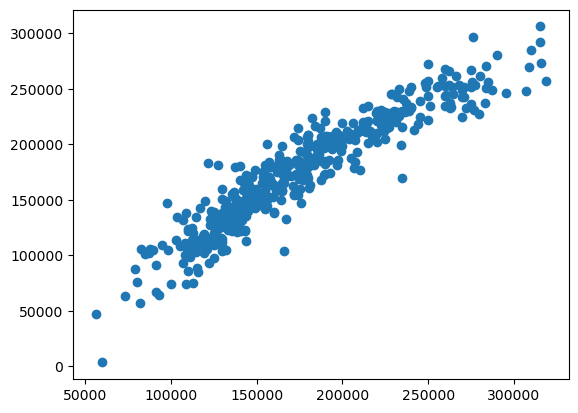

In [21]:
plt.scatter(x=Y_test,y=Y_pred)

#
#
#

# Testing model with test data

In [22]:
test_df=readData("","test")

Data has been read


In [27]:
test_df1=testCleanData(test_df,trainLowerBound,trainUpperBound)

Data has been cleaned


In [30]:
test_df2=trainFeatureEncoding(test_df1,trainOHE,trainFeatureDict)

Features are encoded


In [31]:
test_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 55 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     0 non-null      int64  
 1   MSZoning       0 non-null      int64  
 2   LotArea        0 non-null      int64  
 3   Street         0 non-null      int64  
 4   LotShape       0 non-null      int64  
 5   LandContour    0 non-null      int64  
 6   LotConfig      0 non-null      int64  
 7   LandSlope      0 non-null      int64  
 8   Neighborhood   0 non-null      int64  
 9   Condition1     0 non-null      int64  
 10  Condition2     0 non-null      int64  
 11  BldgType       0 non-null      int64  
 12  HouseStyle     0 non-null      int64  
 13  OverallQual    0 non-null      int64  
 14  OverallCond    0 non-null      int64  
 15  YearBuilt      0 non-null      int64  
 16  YearRemodAdd   0 non-null      int64  
 17  RoofStyle      0 non-null      int64  
 18  RoofMatl       0 non-n

In [33]:
test_df3=featureTransformation(test_df2)

Feature transformation is completed
